# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

## Table of Contents<a class="anchor" id="toc"></a>

* [Install Packages](#imports)
* [Data Prep](#data)
* [Data Exporation](#explore)
* [Feature Reduction](#feature)
* [Outputs](#output)

## Install Packages <a class="anchor" id="imports"></a>
[Back to toc](#toc)

In [1]:
!pip install -U numpy
!pip install -U pandas

    100% |████████████████████████████████| 13.4MB 3.2MB/s eta 0:00:01    98% |███████████████████████████████▋| 13.2MB 33.6MB/s eta 0:00:01
tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
  Found existing installation: numpy 1.12.1
    Uninstalling numpy-1.12.1:
      Successfully uninstalled numpy-1.12.1
    100% |████████████████████████████████| 9.5MB 3.6MB/s eta 0:00:01
    100% |████████████████████████████████| 256kB 22.5MB/s ta 0:00:01
  Found existing installation: python-dateutil 2.6.1
    Uninstalling python-dateutil-2.6.1:
      Successfully uninstalled python-dateutil-2.6.1
  Found existing installation: pandas 0.23.3
    Uninstalling pandas-0.23.3:
      Successfully uninstalled pandas-0.23.3


In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import itertools
import scipy
import scipy.stats as stats

# magic word for producing visualizations in notebook
%matplotlib inline
# Use the theme of ggplot
plt.style.use('ggplot')

pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)

In [3]:
# print versions
import sys
print("Python version")
print (sys.version)
print("Version info.")
print (sys.version_info)
print('numpy')
print(np.__version__)
print('pandas')
print(pd.__version__)

print('matplotlib')
print(matplotlib.__version__)
# print('itertools')
# print(itertools.__version__)
print('scipy')
print(scipy.__version__)


Python version
3.6.3 | packaged by conda-forge | (default, Dec  9 2017, 04:28:46) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]
Version info.
sys.version_info(major=3, minor=6, micro=3, releaselevel='final', serial=0)
numpy
1.19.5
pandas
1.1.5
matplotlib
2.1.0
scipy
1.2.1


## Data prep <a class="anchor" id="data"></a>
[Back to toc](#toc)

1. **Read in Data Dictionary.** I created fieldnames.csv and valuenames.csv by downloading the data dictionaries, finding unique values of the attribute name and saving this as a csv file. I will drop variables that don't have a match to those fields in the data dictionaries. 
2. **Classify Columns.** <br> a. Most of the columns are categorical. I read through the data dictionary and identifed fields that contained numeric data. <br>b. At the data exploration phase I identified columns with more than 100 levels. <br> c. I found fields with a large volume of missing values. <br> d. Columns with a single level having more than 98% of the customers in.
3. **Read data.** Read in the data with all columns being coded as *object* except 2a and 2b (above). 
4. **Clean data** <br> a. I created a list from the Values data dictionary of values that should be coded as NULL by filtering on 'unknown' and 'no transactions known' and then if there were 2 levels I split them across columns. I saved this as a csv. <br> b. Remove customers with missing KBA05 and KBA13 data. This is 30% of the data lost. 
<br> c. Remove 2c and 2d
<br> d. Remove customers with a missing value for 1 or more column. <5% of the data lost.
5. Drop columns missing from the Data Dictionary

In [4]:
# Read in data dictionary fields and combine
fieldnames = pd.read_csv('fieldnames.csv')
list_fieldnames = list(fieldnames['Attribute'].values)

valuenames = pd.read_csv('valuenames.csv')
list_valuenames = list(valuenames['Attribute'].values)

# List of fields in the data dictionaries
dd = list(set(list_valuenames).union(set(list_fieldnames)))

In [5]:
# Classify columns

# Numeric
list_numeric  = [
    'ANZ_HH_TITEL'
    ,'ANZ_PERSONEN'
    , 'MIN_GEBAEUDEJAHR'
    ]

# greater than 100 levels - likely numeric
list_large_lvls  = [
    'LNR'                            
    ,'EINGEFUEGT_AM'                    
    ,'KBA13_ANZAHL_PKW'                 
    ,'ANZ_HAUSHALTE_AKTIV'               
    ,'ANZ_STATISTISCHE_HAUSHALTE'        
    ,'GEBURTSJAHR'     
    ]

# fields with large number of missings
list_missing  = [
'ALTER_KIND4'                    
,'ALTER_KIND3'                   
,'TITEL_KZ'                       
,'ALTER_KIND2'                  
,'ALTER_KIND1'                  
,'KK_KUNDENTYP'                
,'KBA05_BAUMAX'                  
,'AGER_TYP'                      
,'EXTSEL992'                     
,'ALTER_HH'                      
,'W_KEIT_KIND_HH' 
  ]

# Columns with single level with my that 98% of customers in 1 of the levels. 
## Based on clean data after removing KBA05/13, Na rows
list_high_sing_lvl = [
'ANZ_TITEL'
,'D19_TELKO_ONLINE_DATUM'
,'D19_TELKO_ONLINE_QUOTE_12'
,'D19_VERSI_ONLINE_DATUM'
,'D19_VERSI_ONLINE_QUOTE_12'
,'DSL_FLAG'
,'SOHO_KZ'
]

In [6]:
# Read in data types. 

def data_types(customers_csv, list_large_lvls, list_numeric):
    """
    Load in customers data and creates a dictionary with the columns that should be coded as object. 
    """
    
    all_columns = pd.read_csv(customers_csv, nrows=0 , sep=';').columns.tolist()

    object_vars = list(set(all_columns) - set(list_large_lvls) - set(list_numeric))

    dic_dtype = {}
    for var in object_vars:
        dic_dtype.update({var: 'object'})
        
    return dic_dtype


# Run all
dic_dtype = data_types('../../../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', list_large_lvls
                      , list_numeric )

In [7]:
# Read in data. 

def load_data(input_csv, dic_dtype):
    """
    Load in data from filepaths provided.
    """
    
    df = pd.read_csv(input_csv, sep=';',
                      dtype=dic_dtype
                     )
    
    return df

print('Loading data...')
germany = load_data('../../../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', dic_dtype)
print('germany loaded')
customers = load_data('../../../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', dic_dtype)
print('customers loaded')

Loading data...
germany loaded
customers loaded


In [8]:
# Load missing data info

def load_miss_data(missing_csv):
    """
    Load in missing data info and outputs 2 dictionaries of the level that should be NULL.
    """
    missing_values = pd.read_csv(missing_csv)
    
    dic_miss = dict(missing_values[['Attribute','Value']].values)
    dic_miss2 = dict(missing_values[['Attribute','second']].dropna().values)
    
    return dic_miss, dic_miss2

dic_miss, dic_miss2 = load_miss_data('unknown_values.csv')

In [9]:
# Clean data 
def clean_data(df, dropKBA05_13): 
    
    if dropKBA05_13 == 1:
        # Drop customers with missing KBA05 and KBA13 data
        df['KBA05_Missing'] = df['KBA05_SEG7'].isnull()
        df['KBA13_Missing'] = df['KBA13_FORD'].isnull()

        customers_clean =  df[(df['KBA05_Missing'] == False) & (df['KBA13_Missing'] == False)].drop(['KBA05_Missing', 'KBA13_Missing'], axis = 1)

    else:
        customers_clean = df
        
    # Recode Missing categories as Nulls
    for key, value in dic_miss.items():
        try:
            customers_clean[key]=customers_clean[key].apply(lambda x: np.nan if x==value else x)
        except:
            pass

    for key, value in dic_miss2.items():
        try:
            customers_clean[key]=customers_clean[key].apply(lambda x: np.nan if x==value else x)
        except:
            pass

    # Drop columns with high volumes of missing and single values
    list_drop = list(set(list_high_sing_lvl).union(set(list_missing)))
    customers_clean.drop(list_drop, axis = 1, inplace = True)

    # Drop rows with missing values
    customers_clean.dropna(inplace = True)

    # Print shapes before and after cleaning
    shape = customers.shape
    cleanshape = customers_clean.shape
    print(f'Shape of original {shape} ... shape of clean {cleanshape}' ) 
    
    return customers_clean

print('Cleaning data...')
customers_clean = clean_data(customers,1)
print('customers cleaned')
germany_clean = clean_data(germany,1)
print('germany cleaned')

Cleaning data...
Shape of original (191652, 371) ... shape of clean (118961, 351)
customers cleaned
Shape of original (191652, 371) ... shape of clean (466724, 348)
germany cleaned


In [10]:
# Additional step - remove columns not in DD
not_in_ger = list(set(customers_clean.columns.tolist()) - set(germany_clean.columns.tolist()) )
not_in_missvals = list(set(customers_clean.columns.tolist()) - set(dic_miss.keys()) )
not_in_dd = list(set(customers_clean.columns.tolist()) - set(dd) - set(not_in_ger) )

# Drop fields not in data dictionary
germany_clean.drop(not_in_dd, axis = 1, inplace = True)
customers_clean.drop(not_in_dd, axis = 1, inplace = True)

In [11]:
customers_clean.shape

(118961, 271)

In [12]:
germany_clean.shape

(466724, 268)

## Data Exploration <a class="anchor" id="explore"></a>
[Back to toc](#toc)

### Group variables

In [18]:
all_columns_clean = customers_clean.columns.tolist()

# How many levels
counts= customers_clean.nunique(dropna=False)
counts.sort_values(ascending=True, inplace=True)

# Single value - none
single_val_col = counts[counts == 1]
l_single_val_col = list(single_val_col.index.values)

# binary - 4
doube_val_col = counts[counts == 2]
l_binary_val_col = list(doube_val_col.index.values)

In [19]:
# Values that have a single value_count > 98% of the rows
# Commenting out as these columns have been hard-coded in the Data Cleaning stage and removed.

# for col in all_columns_clean:
#     test = customers_clean[col].value_counts().rename_axis('unique_values').reset_index(name='counts')
#     test2= test[test['counts']/customers_clean.shape[0]>0.98]

#     if test2.shape[0] > 0:
#         print(col)

### Visualise

These graphs haven't been tidied as they won't be reported anywhere and just here as an option to have a look at some columns.

In [20]:
# Histogram of features - takes too long to print them all so filter on this list first 
look_cat_cols= ['D19_BANKEN_ONLINE_QUOTE_12'] 

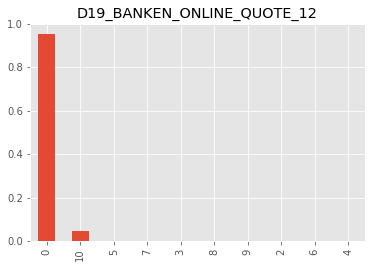

In [21]:
# Graphs - customers
for col in look_cat_cols:
    vals = customers_clean[col].value_counts(dropna=False)
    (vals/customers_clean.shape[0]).plot(kind="bar")
    plt.title(col)
    plt.show()

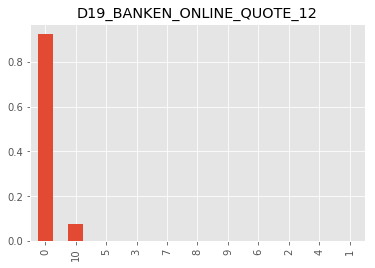

In [22]:
# Graphs - Germany
for col in look_cat_cols:
    vals = germany_clean[col].value_counts(dropna=False)
    (vals/germany_clean.shape[0]).plot(kind="bar")
    plt.title(col)
    plt.show()

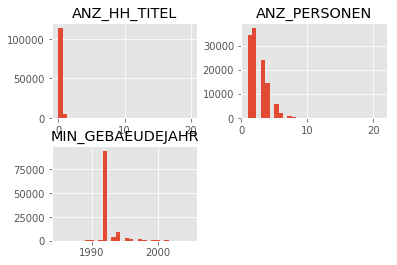

In [23]:
# histograms of numeric fields
customers_clean[list_numeric].hist(bins=30);

## Feature Reduction <a class="anchor" id="feature"></a>
[Back to toc](#toc)

For simplicity, I have removed additional columns namely: numeric and variables with many levels that would seem more continuous in nature or would introduce too much cardinality once encoded. I have also removed 3 variables that have levels with <5 customers as my statistical test wouldn't be appropriate for these.

<br> This section runs a chi-squared test on all the combinations of columns and finds Cramer's V as a measure of how correlated they are to one another. Again for simplicity, it drops one of the correlated variables at random but I would suggest coming back to this and also considering feature importance.
Refs: 
<br> https://www.statology.org/interpret-cramers-v/
<br> https://www.kaggle.com/code/phaethonprime/eda-and-logistic-regression/notebook
<br> <br> I have picked CV cut-offs mentioned on the page above.

In [24]:
cutoff_1 = 0.50
cutoff_2 = 0.35
cutoff_3 = 0.29
cutoff_4 = 0.25
cutoff_5 = 0.22 # conservative all dof>5 will use this one. i.e. will keep more columns

In [25]:
# After running Chi-squared test and printing dof these categorical variables have many levels
many_levels = ['GFK_URLAUBERTYP', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'MIN_GEBAEUDEJAHR', 'LP_LEBENSPHASE_FEIN', 'CAMEO_DEU_2015' ]
# Chi-squared test gives warning as low volumes (<5 customers) in some of the levels
not_tested = ['WOHNLAGE', 'D19_BANKEN_ONLINE_QUOTE_12', 'KBA05_GBZ']

In [26]:
# At this stage for simplicity
# Drop all the numeric, low volumes in some levels, too many levels for a categorical variable

cus_chi_cols = list(set(all_columns_clean) - set(list_large_lvls) - set(list_numeric)  
                       - set(not_tested) -set(many_levels) 
                      )
ger_chi_cols = list(set(all_columns_clean) - set(list_large_lvls) - set(list_numeric)  
                       - set(not_tested) -set(many_levels) 
                      - set(not_in_ger)
                      )

customers_dropv = customers_clean[cus_chi_cols]
germany_dropv = germany_clean[ger_chi_cols]

In [27]:
# https://www.kaggle.com/code/phaethonprime/eda-and-logistic-regression/notebook
def cramers_corrected_stat(conting):
    """ calculate Cramers V statistic for categorical-categorical association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = stats.chi2_contingency(conting)[0]
    n = conting.sum().sum()
    phi2 = chi2/n
    r,k = conting.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1))) , min((kcorr-1), (rcorr-1))

In [28]:
corr_output = pd.DataFrame(columns = ['Col1', 'Col2', 'CramerV', 'dof'])

for col1, col2 in itertools.combinations(cus_chi_cols, 2):

    cramer, dof = cramers_corrected_stat(pd.crosstab(customers_dropv[col1], customers_dropv[col2]))

    corr_output = corr_output.append({'Col1': col1,
                                      'Col2': col2,
                                      'CramerV': cramer,
                                      'dof': dof
                                          }, ignore_index=True)

In [29]:
corrhigh = corr_output.loc[  ((corr_output.CramerV > cutoff_1) & (corr_output['dof'].between(0, 1, inclusive = 'right')))
                           | ((corr_output.CramerV > cutoff_2) & (corr_output['dof'].between(1, 2, inclusive = 'right')))
                           | ((corr_output.CramerV > cutoff_3) & (corr_output['dof'].between(2, 3, inclusive = 'right')))
                           | ((corr_output.CramerV > cutoff_4) & (corr_output['dof'].between(3, 4, inclusive = 'right')))
                           | ((corr_output.CramerV > cutoff_5) & (corr_output['dof']> 4 ))
                          ]

In [30]:
# Sort so that results can reproduced
corrhigh_sorted = corrhigh.sort_values(by=['Col1', 'Col2'] )

In [31]:
# Example
# Consider these pairs of correlated pairs:

# a b
# b c - skipped by if statement
# d e 
# a c - a will be deduped in the keep list
# f b - b will be deduped in the drop list

# Put highly correlated columns into lists
col1 = list(corrhigh_sorted.Col1)
col2 = list(corrhigh_sorted.Col2)

# Set up empty lists
keep_corr = []
drop_corr = []

# Loop
for i in range(1, len(col1)):

    if col1[i] not in drop_corr:
        keep_corr.append(col1[i])
        #dedup
        keep_corr = list(set(keep_corr))

        drop_corr.append(col2[i])
        #dedup
        drop_corr = list(set(drop_corr))


In [32]:
# Keep the fields that are in Customers only
drop_corr.remove('PRODUCT_GROUP')
len(drop_corr)

193

In [33]:
# Drop fields not in data dictionary

customers_FR = customers_dropv.drop(drop_corr, axis = 1)
germany_FR   = germany_dropv.drop(drop_corr, axis = 1)

all_columns_FR = list(customers_FR.columns)

In [34]:
customers_FR.shape

(118961, 64)

In [35]:
germany_FR.shape

(466724, 61)

## Outputs <a class="anchor" id="output"></a>
[Back to toc](#toc)

In [36]:
# split Germany into 2 parts
germany1 = germany_FR.head(266724)
germany2 = germany_FR.tail(200000)

In [37]:
# Create a sample of Germany with the same number of rows as Customer
Germany_samp = germany_FR.sample(n = customers_FR.shape[0], random_state = 12345).copy()

In [38]:
Germany_samp.shape

(118961, 61)

In [39]:
# output to latest to csv - not output because old versions are used for results

# customers_FR.to_csv("customers_FR_new.csv", index=False)
# germany1.to_csv("germany_FR_new1.csv" , index=False)
# germany2.to_csv("germany_FR_new2.csv" , index=False)
# Germany_samp.to_csv("Germany_samp_new.csv" , index=False)

In [7]:
# Read in and Output Train and Test so these can be uploaded to my server at work.
mailout_test = pd.read_csv('../../../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';', dtype=dic_dtype)
mailout_train = pd.read_csv('../../../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';',  dtype=dic_dtype)

In [8]:
# split into 4 parts
train1 = mailout_train.head(22962)
train2 = mailout_train.tail(20000)

test1 = mailout_test.head(22833)
test2 = mailout_test.tail(20000)

In [9]:
# Output all 4 parts to csv
train1.to_csv("train1.csv", index = False)
train2.to_csv("train2.csv", index = False)
test1.to_csv("test1.csv", index = False)
test2.to_csv("test2.csv", index = False)

In [43]:
# for checks 
mailout_train.RESPONSE.value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

In [10]:
# for checks 
mailout_test.shape

(42833, 366)

### This next section replicates the current version of customers_FR, germany_FR and Germany_samp. Previous versions of the code did not produce the same results each time from the Feature Reduction. Therefore if you run this then it will give the same data used in the Unsupervised learning notebook. 

In [47]:
cus_fr_cols = ['KBA13_VORB_0',
 'KBA05_HERST5',
 'KBA13_VORB_2',
 'KBA13_HALTER_55',
 'D19_VERSAND_ONLINE_QUOTE_12',
 'KBA13_CCM_1800',
 'KBA13_HERST_SONST',
 'LP_FAMILIE_GROB',
 'KBA13_VW',
 'KBA13_NISSAN',
 'CJT_GESAMTTYP',
 'D19_TELKO_DATUM',
 'KBA13_KW_0_60',
 'KBA13_MAZDA',
 'KBA05_ANTG3',
 'KBA13_HERST_EUROPA',
 'FINANZ_VORSORGER',
 'PRODUCT_GROUP',
 'KBA13_KMH_251',
 'KBA13_BJ_2004',
 'KBA13_SEG_KLEINST',
 'KBA13_CCM_3000',
 'KBA13_BMW',
 'KBA13_SITZE_5',
 'KBA13_KW_80',
 'D19_VERSI_OFFLINE_DATUM',
 'KBA13_SEG_OBERKLASSE',
 'KBA13_SEG_UTILITIES',
 'KBA13_SEG_WOHNMOBILE',
 'SEMIO_VERT',
 'KBA13_SEG_GELAENDEWAGEN',
 'KBA13_KMH_110',
 'NATIONALITAET_KZ',
 'KBA13_CCM_1500',
 'KBA13_TOYOTA',
 'KBA05_ANTG4',
 'HH_EINKOMMEN_SCORE',
 'KBA13_KRSSEG_VAN',
 'KBA13_KW_90',
 'KBA13_HALTER_20',
 'KBA13_KW_110',
 'KBA13_KMH_140',
 'KBA13_FORD',
 'PLZ8_GBZ',
 'KBA13_CCM_2500',
 'WOHNDAUER_2008',
 'D19_BANKEN_ONLINE_DATUM',
 'KBA05_MODTEMP',
 'ONLINE_PURCHASE',
 'CUSTOMER_GROUP',
 'ARBEIT',
 'KBA13_HALTER_45',
 'PLZ8_ANTG2',
 'KBA13_FAB_ASIEN',
 'RETOURTYP_BK_S',
 'KBA13_SEG_MITTELKLASSE',
 'KBA13_KW_70',
 'REGIOTYP',
 'KBA13_HALTER_40',
 'KONSUMNAEHE',
 'KBA13_KRSAQUOT',
 'GEBAEUDETYP',
 'KBA13_OPEL',
 'D19_VERSI_ANZ_12',
 'KBA13_AUDI',
 'KBA13_HALTER_65']

In [48]:
germ_fr_cols = ['KBA13_VORB_0',
 'KBA05_HERST5',
 'KBA13_VORB_2',
 'KBA13_HALTER_55',
 'D19_VERSAND_ONLINE_QUOTE_12',
 'KBA13_CCM_1800',
 'KBA13_HERST_SONST',
 'LP_FAMILIE_GROB',
 'KBA13_VW',
 'KBA13_NISSAN',
 'CJT_GESAMTTYP',
 'D19_TELKO_DATUM',
 'KBA13_KW_0_60',
 'KBA13_MAZDA',
 'KBA05_ANTG3',
 'KBA13_HERST_EUROPA',
 'FINANZ_VORSORGER',
 'KBA13_KMH_251',
 'KBA13_BJ_2004',
 'KBA13_SEG_KLEINST',
 'KBA13_CCM_3000',
 'KBA13_BMW',
 'KBA13_SITZE_5',
 'KBA13_KW_80',
 'D19_VERSI_OFFLINE_DATUM',
 'KBA13_SEG_OBERKLASSE',
 'KBA13_SEG_UTILITIES',
 'KBA13_SEG_WOHNMOBILE',
 'SEMIO_VERT',
 'KBA13_SEG_GELAENDEWAGEN',
 'KBA13_KMH_110',
 'NATIONALITAET_KZ',
 'KBA13_CCM_1500',
 'KBA13_TOYOTA',
 'KBA05_ANTG4',
 'HH_EINKOMMEN_SCORE',
 'KBA13_KRSSEG_VAN',
 'KBA13_KW_90',
 'KBA13_HALTER_20',
 'KBA13_KW_110',
 'KBA13_KMH_140',
 'KBA13_FORD',
 'PLZ8_GBZ',
 'KBA13_CCM_2500',
 'WOHNDAUER_2008',
 'D19_BANKEN_ONLINE_DATUM',
 'KBA05_MODTEMP',
 'ARBEIT',
 'KBA13_HALTER_45',
 'PLZ8_ANTG2',
 'KBA13_FAB_ASIEN',
 'RETOURTYP_BK_S',
 'KBA13_SEG_MITTELKLASSE',
 'KBA13_KW_70',
 'REGIOTYP',
 'KBA13_HALTER_40',
 'KONSUMNAEHE',
 'KBA13_KRSAQUOT',
 'GEBAEUDETYP',
 'KBA13_OPEL',
 'D19_VERSI_ANZ_12',
 'KBA13_AUDI',
 'KBA13_HALTER_65']

In [49]:
customers_FR_old = customers_clean[cus_fr_cols]
germany_FR_old = germany_clean[germ_fr_cols]
Germany_samp_old = germany_FR_old.sample(n = customers_FR_old.shape[0], random_state = 12345).copy()

# split Germany into 2 parts
germany1_old = germany_FR_old.head(266724)
germany2_old = germany_FR_old.tail(200000)

In [50]:
# output to csv
customers_FR_old.to_csv("customers_FR.csv", index=False)
germany1_old.to_csv("germany_FR1.csv" , index=False)
germany2_old.to_csv("germany_FR2.csv" , index=False)
Germany_samp_old.to_csv("Germany_samp.csv" , index=False)